# Зеркальный спуск  

## Основная часть

__Задача 1. (10 баллов)__ Рассмотрим следующую билинейную задачу на симплексах:
$$
\min_{x \in \mathcal{X}} \max_{y \in \mathcal{Y}} f(x,y) = x^T A y,
$$
где $X = \{ x \in \mathbb{R}^d \mid x_i \geq 0 , \sum_{i=1}^d x_i = 1\}$, $Y = \{ y \in \mathbb{R}^d \mid y_i \geq 0 , \sum_{i=1}^d x_i = 1\}$, $A \in \mathbb{R^{d \times d}}$.

Такую задачу часто называют матричной игрой. В этом задании будет конкретная игра "Вор и полицейский".

Пусть город представляет собой квадрат из $n \times n$ маленьких квадратиков. В каждом квадратике стоит дом и полицейская будка рядом с ним. Пусть так же известны ценность дома для вора $w_{i}$ в квадрате $i$. Каждую ночь вор выбирает, какой дом ограбить, а полицейский выбирает будку, в которой будет дежурить. Вероятность поимки вора, если вор грабит дом в квадрате $j$, а полисмен дежурит в квадрате $i$ равна:
    $$\exp(- \alpha  \cdot \text{dist}(i,j)).$$
Здесь $\alpha > 0$ - некторый параметр, т.е. вероятность уменьшается с увеличением расстояния между квадратами.
Вор хочет максимизировать свою ожидаемую прибыль:
    $$w_j \left(1 -  \exp(- \alpha \cdot \text{dist}(i,j))\right).$$
Полицейский наоборот - минимизировать.

Такую постановку можно формализовать в виде матричной игры: занумеруем все дома от $0$ до $d = n^2 - 1$, получится вектор $w \in \mathbb{R}^{d}$ стоимостей домов. В элемент $A_{ij}$ матрицы $A$ запишем:
$$A_{ij} = w_j \left(1 - \exp(- \alpha \cdot \text{dist}(i,j))\right),$$
т.е. ожидаемую прибыль вора, если он будет грабить дом с номером $j$, а полицейский дежурить в доме с номером $i$. В векторах $x$ и $y$ будут хранится вероятностные стратегии для полицийского и вора: вероятность выбрать тот или иной дом для дежурства или грабежа. Цель задания найти равновестные стратегии.

Возьмем $n = 10$. Следующий код генерирует некоторое распределение ценностей домов $w$ и матрицу $A$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
def dist(i, j, n):
    i_x = i % n
    i_y = i // n
    j_x = j % n
    j_y = j // n
    return np.linalg.norm([i_x - j_x, i_y - j_y], 2)

def game(n = 10):
    i_max = (n // 2) * (n + 1)
    w = np.array([1. / (dist(i, i_max, n) + 20) for i in range(n ** 2)])
    A = np.zeros([n ** 2, n ** 2])
    for i in range(n ** 2):
        for j in range(n ** 2):
            A[i,j] = w[j] * (1 - np.exp(- dist(i, j, n)))
    return A, w

In [16]:
n = 10
A, w = game(n)

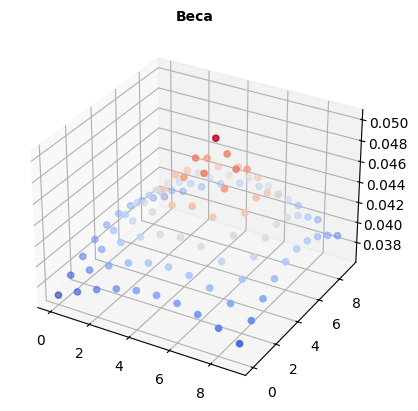

In [7]:
X, Y = np.meshgrid(range(n), range(n))
X = X.ravel()
Y = Y.ravel()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X, Y, w, c = w, cmap=cm.coolwarm)
ax.set_title(f"Веса", fontsize = 10, fontweight='bold')

plt.show()

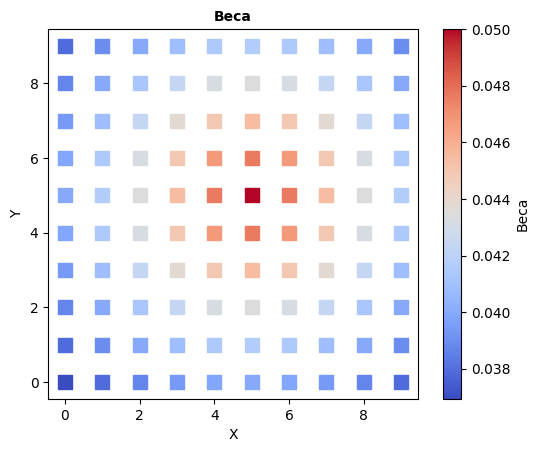

In [8]:
fig, ax = plt.subplots()

sc = ax.scatter(X, Y, c=w, cmap='coolwarm', marker='s', s=100)
ax.set_aspect('equal', adjustable='box')

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Веса')

ax.set_title("Веса", fontsize=10, fontweight='bold')
ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

На графиках выше визуализированны стоимости домов в городе: в центре самые дорогие, на окраинах бедные.


На лекциях мы познакомились с экстраградиентным методом и зеркальным спуском. Первый предназначен для решения седловых задач, второй - для лучшего учета "геометрии" задачи. Попробуем объединить эти две идеи и получим следующий метод:
\begin{align}
x^{k+1/2} &= \arg\min_{x \in \mathcal{X}} (\gamma\langle \nabla_x f(x^k, y^k), x\rangle + V(x,x^k))
\\
y^{k+1/2} &= \arg\min_{y \in \mathcal{Y}} (\gamma\langle - \nabla_y f(x^k, y^k), y\rangle + V(y,y^k))
\\
x^{k+1} &= \arg\min_{x \in \mathcal{X}} (\gamma\langle \nabla_x f(x^{k+1/2}, y^{k+1/2}), x\rangle + V(x,x^k))
\\
y^{k+1} &= \arg\min_{y \in \mathcal{Y}} (\gamma\langle - \nabla_y f(x^{k+1/2}, y^{k+1/2}), y\rangle + V(y,y^k)),
\end{align}
где $\gamma > 0$ - шаг метода.
Для краткости введем обозначения, как на лекции:
$$
z = \binom{x}{y} \quad F(z) = F(x,y) = \binom{\nabla_x f(x, y)}{- \nabla_y f(x, y)}
$$
В новых обозначениях метод выше можно переписать, как
\begin{align}
z^{k+1/2} &= \arg\min_{z \in \mathcal{Z}} (\gamma\langle F(z^k), z\rangle + V(z,z^k))
\\
z^{k+1} &= \arg\min_{z \in \mathcal{Z}} (\gamma\langle F(z^{k+1/2}), z\rangle + V(z,z^k)).
\end{align}

Пусть оператор $F$ является $L$-Липшицевым (следует из Липшицевости градиентов):
$$
\| F(z_1) - F(z_2) \|_* \leq L \| z_1 - z_2\|,
$$
а функция $f$ является выпукло-вогнутой.

__а). (3 балла)__ Для игровой задачи запишите явный вид метода, (на лекции мы тоже работали с симплексом). Реализуйте в виде кода.

__Решение__

В этом случае $\nabla_x f(x^k, y^k) = Ay$, $~~~\nabla_y f(x^k, y^k) = A^Tx$

Для "половинного" обновления формула будет такая же, как на лекции. То есть

$$x_i^{k + 1/2} = \frac{x_i^k exp(-\gamma [\nabla_x f(x^k, y^k)]_i)}{\sum\limits_{j=1}^{d} x_j^k exp(-\gamma [\nabla_x f(x^k, y^k)]_j)}$$

$$y_i^{k + 1/2} = \frac{y_i^k exp(\gamma [\nabla_y f(x^k, y^k)]_i)}{\sum\limits_{j=1}^{d} y_j^k exp(\gamma [\nabla_y f(x^k, y^k)]_j)}$$

В случае $y$ знак отличается, как и в исходной формуле.

Для окончательного шага отличие будет только в том, что градиент берётся в "половинной" точке. То есть

$$x_i^{k + 1} = \frac{x_i^k exp(-\gamma [\nabla_x f(x^{k + 1/2}, y^{k + 1/2})]_i)}{\sum\limits_{j=1}^{d} x_j^k exp(-\gamma [\nabla_x f(x^{k + 1/2}, y^{k + 1/2})]_j)}$$

$$y_i^{k + 1} = \frac{y_i^k exp(\gamma [\nabla_y f(x^{k + 1/2}, y^{k + 1/2})]_i)}{\sum\limits_{j=1}^{d} y_j^k exp(\gamma [\nabla_y f(x^{k + 1/2}, y^{k + 1/2})]_j)}$$

In [26]:
# ВАШЕ РЕШЕНИЕ (Code и Markdown)
def gradient_x(A, y):
    return np.dot(A, y)

def gradient_y(A, x):
    return np.dot(A.T, x)

def fraction(v): # Соответствует последней формуле из лекции
    return v / np.sum(v)

def mirror_descent_game(A, w, n, alpha, gamma, eps=1e-8, max_iter=1000):
    d = n * n
    x = np.ones(d) / d  # Стратегия вора
    y = np.ones(d) / d  # Стратегия полицейского

    errors = []
    
    for k in range(max_iter):
        grad_x = gradient_x(A, y)
        x_half = fraction(x * np.exp(-gamma * grad_x))
        
        grad_y = gradient_y(A, x)
        y_half = fraction(y * np.exp(gamma * grad_y))

        grad_x_half = gradient_x(A, y_half)
        x_next = fraction(x * np.exp(-gamma * grad_x_half))

        grad_y_half = gradient_y(A, x_half)
        y_next = fraction(y * np.exp(gamma * grad_y_half))

        x, y = x_next, y_next

        errors.append(gap(x, y, A))
        if errors[-1] <= eps:
            break

    return x, y, errors

__б). (2 балла)__ Докажите, что константа $L$ для игровой задачи может быть оценена как максимальное (по модулю) собственное число матрицы $A$.

__Решение__

Поскольку $F(z) = \binom{\nabla_x f(x, y)}{- \nabla_y f(x, y)} = \binom{Ay}{-Ax}$,

$$ F(z_1) - F(z_2) = \binom{A(y_1 - y_2)}{-A(x_1 - x_2)}$$,

откуда видно, что $L$ можно оценить собственным числом матрицы $A$.

__в). (1 балл)__ В качестве критерия используйте следующее выражение:
$$
\text{gap}(x^k, y^k) = \max_{y \in \mathcal{Y}} f(x^k, y) - \min_{x \in \mathcal{X}} f(x, y^k), \quad \text{или} \quad \text{gap}\left( \frac{1}{k} \sum_{i=0}^{k-1} x^i, \frac{1}{k}\sum_{i=0}^{k-1} y^k \right)
$$
Выпишите явный вид подсчета $\text{gap}(x^k, y^k)$ и реализуйте его (задача не зря называется билинейной).

__Решение__

$f(x^k, y)$ - это фактически скалярное произведение векторов. В задании 5 уже было доказано, что argmax по $y$ на симплексе от такого выражения будет представлять собой вектор, у которого нули везде кроме одной позиции. В нашем случае вектор, на который умножается $y$ - это $A^T x_k$. Для минимума (второе слагаемое) аналогично, но вектор, на который умножается $x$ - это $A y_k$

In [24]:
# ВАШЕ РЕШЕНИЕ (Code и Markdown)
def gap(x_k, y_k, A):
    max_ = np.max(np.dot(A.T, x_k))

    min_ = np.min(np.dot(A, y_k))

    return max_ - min_

__г). (3 балла)__ С помощью реализованного метода решите игровую задачу. Рекомендуется подбирать шаг и брать его значительно больше $\frac{1}{L}$. Постройте график сходимости: значение критерия сходимости от номера итерации.

1.0 0.9999999999999999
4.4216379051357784e-06 9.600179533749844e-07


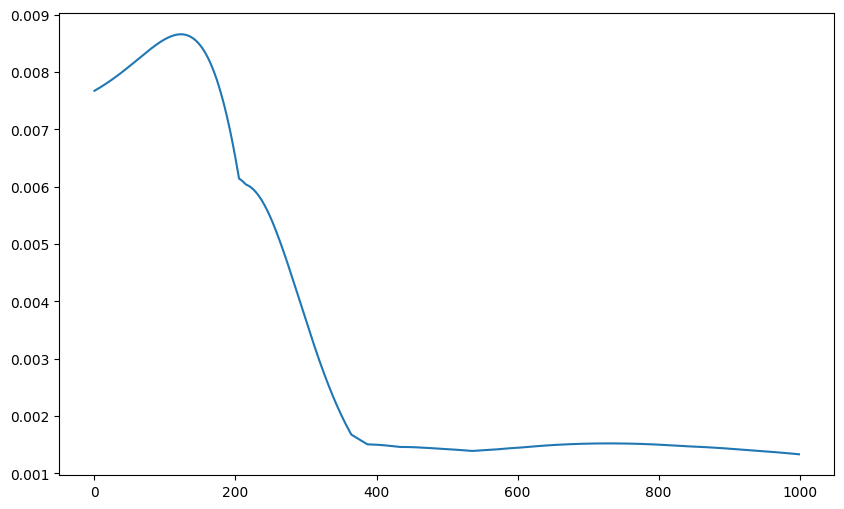

In [37]:
# ВАШЕ РЕШЕНИЕ (Code и Markdown)

L = np.max(np.abs(np.linalg.eig(A)[0]))
gamma_ = 10 / L

x_star, y_star, errors = mirror_descent_game(A, w, n, alpha=1, gamma=gamma_, eps=1e-8, max_iter=1000)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(errors)

# Проверка, что ограничения выполняются
print(np.sum(x_star), np.sum(y_star))
print(np.min(x_star), np.min(y_star))

__д). (1 балл)__ Визуализируйте решение $x^*$ и $y^*$ на карте города. В этом может помочь визуализация весов выше. Сделайте вывод. Насколько результат кажется натуральным и интепретируемым?

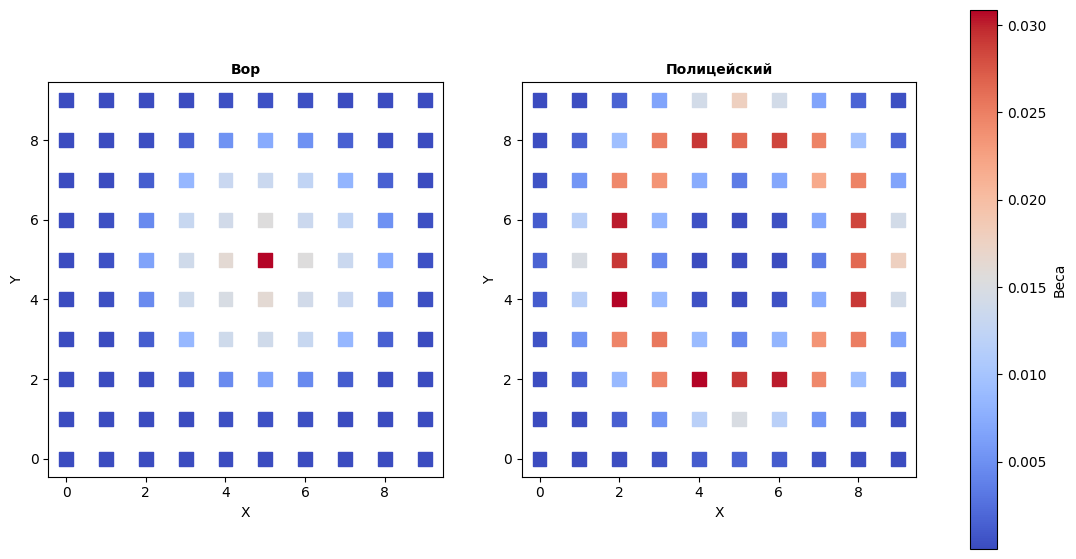

In [35]:
# ВАШЕ РЕШЕНИЕ (Code и Markdown)
X, Y = np.meshgrid(range(n), range(n))
X = X.ravel()
Y = Y.ravel()

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
sc = ax[0].scatter(X, Y, c=x_star, cmap='coolwarm', marker='s', s=100)
ax[0].set_aspect('equal', adjustable='box')

ax[0].set_title("Вор", fontsize=10, fontweight='bold')
ax[0].set_xlabel("X")
ax[0].set_ylabel("Y")

sc = ax[1].scatter(X, Y, c=y_star, cmap='coolwarm', marker='s', s=100)
ax[1].set_aspect('equal', adjustable='box')

ax[1].set_title("Полицейский", fontsize=10, fontweight='bold')
ax[1].set_xlabel("X")
ax[1].set_ylabel("Y")

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Веса')

plt.show()

Вроде выглядит довольно правдоподобно: вор стремится ограбить самые "богатые" дома, а полицейский дежурит вокруг, чтобы быть близко к нему. Немного смущает, что у окружности, которая прослеживается на распределении полицейского, довольно большой радиус, хотя на распределение вора имеет острый пик; тем не менее, это ничему не противоречит. По крайней мере, центральная симметрия не нарушена.

### Другое расределение

Стало интересно проверить результаты игры на другом распределении ценностей домов. Результаты ниже

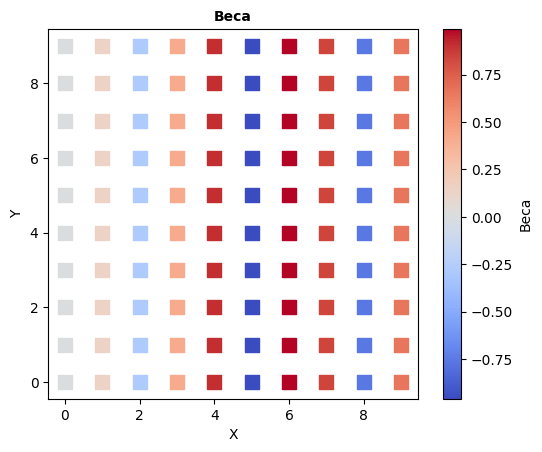

1.0 1.0
5.83800781285082e-31 5e-324


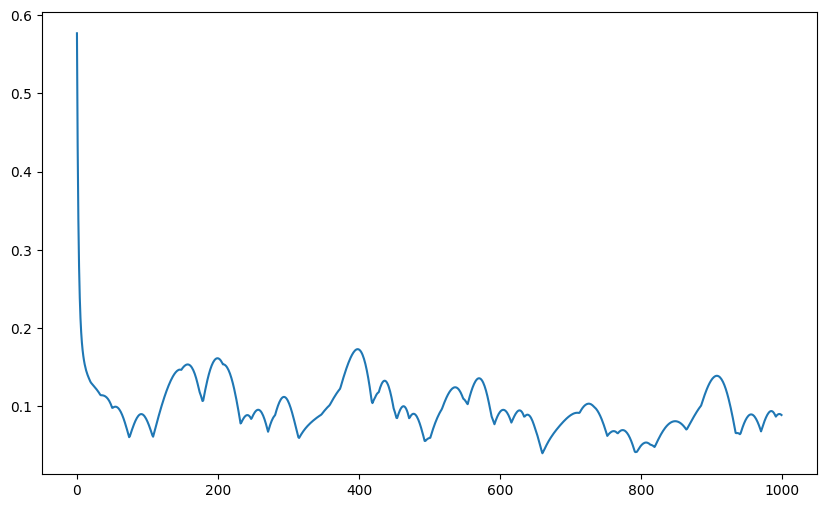

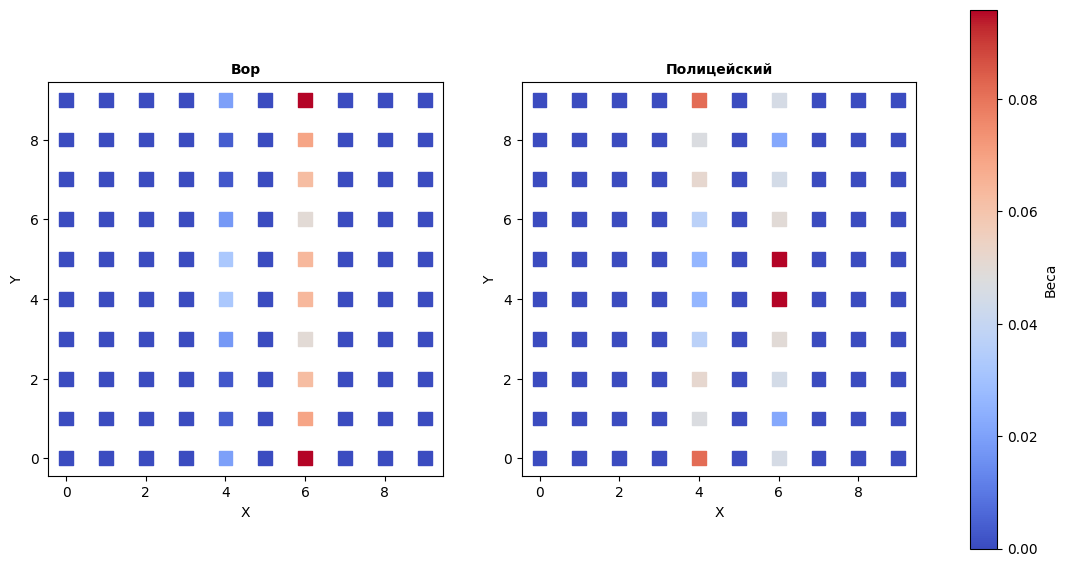

In [44]:
def sin(n = 10):
    i_max = (n // 2) * (n + 1)
    w = np.array([np.sin(i * 3 % n) for i in range(n ** 2)])
    A = np.zeros([n ** 2, n ** 2])
    for i in range(n ** 2):
        for j in range(n ** 2):
            A[i,j] = w[j] * (1 - np.exp(- dist(i, j, n)))
    return A, w

n = 10
A, w = sin(n)

fig, ax = plt.subplots()

sc = ax.scatter(X, Y, c=w, cmap='coolwarm', marker='s', s=100)
ax.set_aspect('equal', adjustable='box')

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Веса')

ax.set_title("Веса", fontsize=10, fontweight='bold')
ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

L = np.max(np.abs(np.linalg.eig(A)[0]))
gamma_ = 10 / L

x_star, y_star, errors = mirror_descent_game(A, w, n, alpha=1, gamma=gamma_, eps=1e-8, max_iter=1000)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(errors)

# Проверка, что ограничения выполняются
print(np.sum(x_star), np.sum(y_star))
print(np.min(x_star), np.min(y_star))

X, Y = np.meshgrid(range(n), range(n))
X = X.ravel()
Y = Y.ravel()

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
sc = ax[0].scatter(X, Y, c=x_star, cmap='coolwarm', marker='s', s=100)
ax[0].set_aspect('equal', adjustable='box')

ax[0].set_title("Вор", fontsize=10, fontweight='bold')
ax[0].set_xlabel("X")
ax[0].set_ylabel("Y")

sc = ax[1].scatter(X, Y, c=y_star, cmap='coolwarm', marker='s', s=100)
ax[1].set_aspect('equal', adjustable='box')

ax[1].set_title("Полицейский", fontsize=10, fontweight='bold')
ax[1].set_xlabel("X")
ax[1].set_ylabel("Y")

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Веса')

plt.show()

Бедные дома никому не нужны, полицейский сидит в центре богатой "улицы", а вор, соответственно, грабит на её окраинах. Заметим, что в этом случае сходимость намного хуже. Я предполагаю (проверять/визуализировать немного лень), что в процессе "игры" вор меняет распределение между центральными и крайними домами, а полицейский подстраивается под это. Этому соответствуют пики на графике сходимости.

## Дополнительная часть

__Задача 1. (10 баллов)__

При обучении нейронных сетей часто возникает проблема с шумом: картинки, которые правильно распознаются моделью, после добавление шума, малозаметно для человека меняются, а модель начинает ошибаться. В данном задании мы будем исследовать влияние шума на качество распознавания модели и пытаться решить проблему с помощью обучаемого шума.

__а). (2 балла)__ Обучение базовой модели


В данном задании мы будем решать задачу классификации: определять к какому классу относится объект (какая у него метка, label).
В нашем случае объектами будут выступать изображения, а классами — что изображено на картинке.


In [ ]:
import torch
import matplotlib.pyplot as plt

При обучении модели для ускорения работы используем GPU (а в случае новых процессоров Apple Silicon - MPS). Для этого в pytorch используется концепция "устройства" (device): где хранятся данные и выполняются операции.

Определим `DEVICE`:

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
DEVICE

Подготовим данные для обучения. Библиотека pytorch предоставляет удобные функции для загрузки и обработки популярных датасетов.

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

Загрузим популярный датасет CIFAR10: он содержит изображения 32x32 пикселей, разбитые на 10 классов; каждый класс записан как число, хотя он соотвествует конкретному классу (например, класс 0 — это изображения самолетов). Подробнее можно почитать [здесь](https://www.cs.toronto.edu/~kriz/cifar.html).

Если первый раз запускаете, то придется подождать, пока данные скачаются и сохранятся локально. Повторное запуск кода не потребует этого.

При загрузке сразу применим к данным преобразования: нормализуем и приведем к нужному виду.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = CIFAR10(root='./data', train=False, transform=transform, download=True)

Ещё одна концепция в pytorch - DataLoader. Она позволяет удобно подавать данные на вход модели батчами и, при необходимости, перемешивать их.

In [ ]:
batch_size = 64 # размер одного батча: сколько изображений будет подаваться на вход модели за один раз

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True) # drop_last=True, чтобы не было батчей, которые меньше batch_size
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

Теперь пришло время определить модель. Определим архитектуру AlexNet, которая является одной из самых известных сверточных нейронных сетей и хорошо подходит для задач классификации изображений. AlexNet состоит из нескольких сверточных слоев и полносвязных слоев.

Вот изображение архитектуры AlexNet (оно для другой задачи, в нашем случае размер входного изображения и количество классов отличаются, поэтому некоторые параметры в слоях изменились):

![AlexNet](https://www.researchgate.net/publication/372113543/figure/fig4/AS:11431281220692710@1706534406530/Visualization-of-the-fine-tuned-AlexNet-architecture.png)

[Ссылка](https://github.com/soapisnotfat/pytorch-cifar10/blob/master/models/AlexNet.py) на репозиторий, откуда был частично взят код


In [ ]:
import torch.nn as nn # модуль для работы непосредственно с моделями
import torch.nn.functional as F # модуль для работы с функциями активации

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        return logits

Создадим модель

In [ ]:
model = AlexNet(num_classes=...).to(DEVICE)
# ВАШЕ РЕШЕНИЕ: заполните пропуски

Теперь определим конкретный вид функции потерь. На выход модель выдает вектор предсказание распределения вероятностей между классами, истинный же вектор вероятностей — все нули, кроме единицы на месте соответствущем верному классу. Кросс-энтропия измеряет расстояние между этими распределениями.

In [ ]:
criterion = nn.CrossEntropyLoss() # отметим что функция потерь принимает на вход "logits", это уже учтено в нашей модели (нет применения softmax в конце)

В качестве оптимизатора будем использовать стохастический градиентный спуск (SGD).

In [ ]:
learning_rate = 0.01 # тот самый шаг оптимизации градиентного спуска
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Реализуйте функцию для подсчета точности модели

In [ ]:
# ВАШЕ РЕШЕНИЕ: заполните пропуски

def test_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = ...
            total += ...
            correct += ...
    accuracy = ...
    return accuracy

Теперь подготовим функцию для полного цикла обучения модели. Она будет принимать модель, оптимизатор, функцию потерь и количество эпох, на выход будет выводить значение функции потерь и точность (на тренировочных и тестовых данных) на каждой эпохе.

In [ ]:
from tqdm import tqdm # для прогрессбара

def train_model(model, optimizer, criterion, epochs):
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    model.train()
    for epoch in range(epochs):
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', leave=True) as pbar_batch:
            for images, labels in train_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                # ВАШЕ РЕШЕНИЕ: заполните пропуски
                ...  # Обнуляем градиенты, иначе они будут прибавляться к предыдущим (метод optimizer)
                outputs = ...  # Получаем предсказания модели
                loss = ... # Вычисляем функцию потерь используя outputs и labels
                ... # Вычисляем градиенты c помощью применения алгоритма обратного распространения к функции потерь (метод loss)
                ... # Обновляем параметры модели --- делаем шаг оптимизатора (метод optimizer)

                pbar_batch.update(1)

            # ВАШЕ РЕШЕНИЕ: реализуйте подсчёт и логирование функции потерь и точности
            # подсказка: чтобы получить только значение loss, используйте loss.item()
            ...

            print(f'Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Test Accuracy: {test_accuracies[-1]}')

    return train_losses, train_accuracies, test_accuracies


Теперь непосредственно запустим обучение модели

In [ ]:
# обучение на А100 занимает порядка 4 минут. Если у вас одна эпоха по времени ранится дольше 14 секунд, то рекомендуем снизить количество эпох до 16
train_losses, train_accuracies, test_accuracies = train_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    epochs=32
)


Постройте графики зависимости функции потерь и точности от номера эпохи.

In [ ]:
# ВАШЕ РЕШЕНИЕ:
...


__б). (1 балл)__ В этом пункте мы будем исследовать влияние случайного шума на качество распознавания модели.

Реализуйте функцию для добавления случайного шума из ограниченного шара.
Имеется в виду, что к каждому пикселю изображения добавляется шум, который выбирается из какого-то распределения, которое ограничено по модулю `max_noise`.


In [ ]:
# ВАШЕ РЕШЕНИЕ: заполните пропуски

def add_random_noise(image, max_noise):
    noise = ...
    return image + noise

Модифицируйте функцию для тестирования модели, чтобы она принимала на вход изображения с шумом.

In [ ]:
# ВАШЕ РЕШЕНИЕ: заполните пропуски

def test_model_noise(model, loader, max_noise=0.1):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            noisy_images = add_random_noise(images, max_noise)
            outputs = model(noisy_images)  # Используем зашумленные изображения для предсказания
            _, predicted = ...
            total += ...
            correct += ...
    accuracy = ...
    return accuracy


Посмотрите, как изменилась точность на тестовых данных с и без добавления шума.

In [ ]:
# ВАШЕ РЕШЕНИЕ:
...

__в). (1 балл)__ Изучите статью о добавлении специализированного шума, реализуйте метод из статьи и посмотрите изменения в точности.

В [статье](https://arxiv.org/pdf/1312.6199) подробно разбираются так называемые adversarial attacks, цель которых - добавить шум, который максимально затруднит распознавание модели, при этом будет мало заметен для человека. Изучите статью и реализуйте один из методов добавления шума.

In [ ]:
# ВАШЕ РЕШЕНИЕ: заполните пропуски

def add_adversarial_noise(images,  model=..., max_noise=...):
    ...

Посмотрите, как изменилась точность на тестовых данных с и без добавления шума.

In [ ]:
# ВАШЕ РЕШЕНИЕ:
...

__г). (6 баллов)__ Добавим подъём по шуму.



До этого момента наша задача выглядела вот так
$$
\min_{x \in \mathbb{R}} \left[ \frac{1}{n} \sum_{i=1}^n L\big(g(x, a_i),b_i\big) \right]
$$
где $a_i$ — входные данные, $b_i$ — метки, $g(\cdot, \cdot)$ — модель, $x$ — параметры модели, $L(\cdot,\cdot)$ — функция потерь.

Теперь добавим дополнительно $y_i$ — шум модели для изображения $i$.

Задача будет выглядеть вот так
$$
\min_{x \in \mathbb{R}} \max_{y \in [-\epsilon,+\epsilon]^n} \left[ \frac{1}{n} \sum_{i=1}^n L\big(g(x, a_i + y_i),b_i\big) \right]
$$

В прошлых пунктах мы заметили, что добавление малозаметного случайного шума может значительно изменять ответы модели. Логично ожидать, что модель будет устойчива к небольшим и незаметным изменениям входных данных (в каком-то смысле робастность модели, устойчивость к шуму). А если добавлять шум специализированным образом, это может привести к тому, что модель будет выдавать неправильные ответы практически везде.

Мы стремимся улучшить качество нашей модели, подбирая наиболее "плохой" шум и обучая модель как на обычных, так и на зашумленных изображениях. Мы будем обучать шум отдельно для каждого изображения.

Создадим тензор, который для каждого батча изображений будет хранить шум для каждого изображения в батче.

In [ ]:
# ВАШЕ РЕШЕНИЕ: заполните пропуски

noise_per_image = torch.empty(len(train_loader), train_loader.batch_size, 3, 32, 32).to(DEVICE)
# пояснение:
# len(train_loader) - количество батчей в train_loader
# train_loader.batch_size - размер батча
# 3 - количество каналов в изображении (RGB)
# 32, 32 - размер изображения

# напоминание: выше мы специально указали в train_loader drop_last=True,
# чтобы не было батчей, которые меньше batch_size; это оказалось очень полезно сейчас

for i, (images, labels) in enumerate(train_loader):
    noise_per_image[i] = ... # используйте функцию add_random_noise

Создадим оптимизатор для нашего тензора шума. Подумайте, как сделать так, чтобы оптимизатор именно поднимался по шуму (то есть увеличивал значение функции потерь).

In [ ]:
# ВАШЕ РЕШЕНИЕ:

noise_optimizer = torch.optim.SGD([noise_per_image], lr=0.01) # здесь свой lr, который не обязательно должен быть такой же, как и для модели

# Изменим направление градиента для подъема по шуму
... # подсказка: изучите как хранится lr в noise_optimizer (google, первые ссылки)


# отметим, что "по-хорошему" мы должны были бы сделать отдельный оптимизатор для шума,
# в котором сразу будет подъем и проекция, но мы не будем этого делать, чтобы не усложнять
# но если хотите, можете попробовать!

Теперь модернизируйте функцию `train_model_noise`, добавив в цикл обучения градиентный подъём по шуму для каждого класса изображений отдельно.

Остановимся здесь чуть подробнее. В каждом цикле обучения добавятся следующие шаги:
- Обучение модели на исходном батче изображений
- Шаг оптимизатора модели
- Обучение модели на модифицированном с помощью шума батче изображений
- Шаг оптимизатора модели
- Обновление шума:
    - Шаг оптимизатора шума
    - Проекция шума на шар

In [ ]:
# ВАШЕ РЕШЕНИЕ: заполните пропуски

def train_model_noise(model, optimizer, noise, noise_optimizer, criterion, epochs, max_noise=0.1):
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    test_noise_accuracies = []

    for epoch in range(epochs):
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', leave=True) as pbar_batch:
            for i, (images, labels) in enumerate(train_loader):
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                # ВАШЕ РЕШЕНИЕ: заполните пропуски
                # Обучение модели на исходном изображении, как раньше
                ...

                # Обучение модели на модифицированном изображении с шумом
                ...


            # ВАШЕ РЕШЕНИЕ: реализуйте подсчёт и логирование функции потерь и точности
            ...

            print(f'Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Test Accuracy: {test_accuracies[-1]}, Test Noise Accuracy: {test_noise_accuracies[-1]}')


Не забудем создать новый экземпляр модели и оптимизатор для нее

In [ ]:
# ВАШЕ РЕШЕНИЕ: заполните пропуски

model_noise = ...
optimizer_noise = ...

Теперь запустим обучение модели (учтите для чистоты эксперимента, что мы делаем два шага для модели: на обычных изображениях и на модифицированных с помощью шума, поэтому количество эпох должно быть в два раза меньше, чем для обычной модели)

In [ ]:
# ВАШЕ РЕШЕНИЕ: заполните пропуски

train_losses, train_accuracies, test_accuracies, test_noise_accuracies = train_model_noise(
    model=...,
    optimizer=...,
    noise=...,
    noise_optimizer=...,
    criterion=...,
    epochs=16, # возьмите в два раза меньше, чем брали для обычной модели
    max_noise=0.1
)

Постройте графики зависимости функции потерь и точности от номера эпохи. Постройте на одном графике точность на обычных и модифицированных с помощью шума изображениях.

In [ ]:
# ВАШЕ РЕШЕНИЕ:
...

Убедитесь, что модель стала более робастной. Что можно сказать о результатах?

**ВАШЕ РЕШЕНИЕ**